# Import libraries

In [1]:
import pandas as pd
import numpy as np
import nltk

from collections import Counter

from sklearn import clone

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

%matplotlib inline

# Import dataset

In [2]:
df = pd.read_csv('../../Data/tribe_dynamics_data.csv')
df.head(1)

,Unnamed: 0,Unnamed: 0.1,brand_id,worker_id,mturker,post_hash,answer,date,duration_seconds,text,model_decision,timestamped_model,lang
0,0,0,18792,TRIBE_103_allayne.low@gmail.com,False,3ca62dcea583b7aa204fc52fe6b2826c,False,2017-07-16,NaN,・\r\nケイト スペード ニューヨークの\r\n2017Fall Collectionに招...,False,NaN,ja


In [3]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.head(1)

,brand_id,worker_id,mturker,post_hash,answer,date,duration_seconds,text,model_decision,timestamped_model,lang
0,18792,TRIBE_103_allayne.low@gmail.com,False,3ca62dcea583b7aa204fc52fe6b2826c,False,2017-07-16,NaN,・\r\nケイト スペード ニューヨークの\r\n2017Fall Collectionに招...,False,NaN,ja


In [4]:
df_small = df[['text','lang','model_decision','answer','mturker']]
df_small.head(3)

,text,lang,model_decision,answer,mturker
0,・\r\nケイト スペード ニューヨークの\r\n2017Fall Collectionに招...,ja,False,False,False
1,青春日記【挨拶のハグじゃダメなの】\r\n僕が中学3年生の時だ。\r\n高山私立松倉中学校と...,ja,False,False,False
2,fabric&thingsで本日のみ開催しております\r\nいちごのプチレストラン La F...,ja,False,False,False


### Extract posts of just one language

In [5]:
language = 'en' # Change here to test a different language
lang_df = df_small[df_small.lang == language]
lang_df.head(3)

,text,lang,model_decision,answer,mturker
67,"(near) PORTLAND, OR: Shye Girl and Joey are at...",en,False,False,False
68,Remember 16 year old Daisy (center) who was fo...,en,False,False,False
69,"(near) PORTLAND, OR: 7 year old Maia was so cl...",en,False,False,False


In [6]:
lang_df.shape

(9426, 5)

In [7]:
# Remove perfect duplicates
lang_no_dup_df = lang_df.drop_duplicates(keep='first', inplace=False)
lang_no_dup_df.shape

(2610, 5)

In [8]:
print('Dropped {} completely equal samples'.format(lang_df.shape[0]-lang_no_dup_df.shape[0]))

Dropped 6816 completely equal samples


# Models computation

In [9]:
# Array with all posts text
texts_arr = lang_no_dup_df.text.values

In [10]:
# 'Ground truth' labels
y_true = lang_no_dup_df.answer.values
# Tribe's predicted labels
y_tribe = lang_no_dup_df.model_decision.values

In [11]:
print("Dataset balance:")
print("True labels: {}".format(Counter(y_true)[True]))
print("False labels: {}".format(Counter(y_true)[False]))

Dataset balance:
True labels: 299
False labels: 2311


## Bag of words

In [12]:
# Bag of words
#count_vect = CountVectorizer(stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1,2))
count_vect = CountVectorizer()
X_bag = count_vect.fit_transform(texts_arr)
X_bag.shape

(2610, 37827)

In [13]:
# TF-IDF on the vectorized dataset
X_tfidf = TfidfTransformer().fit_transform(X_bag)
X_tfidf.shape

(2610, 37827)

If you have fairly little data and you are going to train a supervised classifier, then machine learning theory says you should stick to a classifier with high bias. For example, there are theoretical and empirical results that Naive Bayes does well in such circumstances, although this effect is not necessarily observed in practice with regularized models over textual data. At any rate, a very low bias model like a nearest neighbor model is probably counterindicated. Regardless, the quality of the model will be adversely affected by the limited training data.

In [14]:
random_seed = 231

classifiers = [
    ('Naive Bayes', MultinomialNB()),
    #('Gaussian Naive Bayes', GaussianNB()), # only works with dense matrices
    ('Logistic Regression (no reg.)', LogisticRegression(C=1e6, random_state=random_seed, n_jobs=-1)),
    ('Logistic Regression (some reg.)', LogisticRegression(C=1e-2, random_state=random_seed, n_jobs=-1)),
    ('Linear SVM (no reg.)', LinearSVC(C=1e6, random_state=random_seed)),
    ('Linear SVM (some reg.)', LinearSVC(C=1e-2, random_state=random_seed))
    ]

In [15]:
# Stratified CV folds
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

In [16]:
print('Bag of words - 10-fold cross validation accuracy:')

for (model_name,clf) in classifiers:    
    scores = cross_val_score(clone(clf), X_bag, y_true, cv=folds, scoring='accuracy', n_jobs=-1)
    print('{}: \t {:.2f} +/- {:.2f}'.format(model_name, np.mean(scores), np.std(scores)))

Bag of words - 10-fold cross validation accuracy:
Naive Bayes: 	 0.83 +/- 0.02
Logistic Regression (no reg.): 	 0.83 +/- 0.02
Logistic Regression (some reg.): 	 0.88 +/- 0.01
Linear SVM (no reg.): 	 0.75 +/- 0.07
Linear SVM (some reg.): 	 0.86 +/- 0.02


In [17]:
print('TF-IDF - 10-fold cross validation accuracy:')

for (model_name,clf) in classifiers:    
    scores = cross_val_score(clone(clf), X_tfidf, y_true, cv=folds, scoring='accuracy', n_jobs=-1)
    print('{}: \t {:.2f} +/- {:.2f}'.format(model_name, np.mean(scores), np.std(scores)))

TF-IDF - 10-fold cross validation accuracy:
Naive Bayes: 	 0.89 +/- 0.00
Logistic Regression (no reg.): 	 0.83 +/- 0.01
Logistic Regression (some reg.): 	 0.89 +/- 0.00
Linear SVM (no reg.): 	 0.81 +/- 0.05
Linear SVM (some reg.): 	 0.89 +/- 0.00


In [18]:
print("Tribe's model accuracy:\t{:.2f}".format(accuracy_score(y_true, y_tribe)))

Tribe's model accuracy:	0.92


# AUC

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_bag, y_true, test_size=.2, random_state=random_seed)

clf = LogisticRegression(C=1e-3, random_state=random_seed)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

print("AUC ROC curve:\t{:.2f}".format(roc_auc_score(y_test, y_score[:,1])))
print("AUC Precision-Recall curve:\t{:.2f}".format(average_precision_score(y_test, y_score[:,1])))

AUC ROC curve:	0.73
AUC Precision-Recall curve:	0.35


# ROC plot

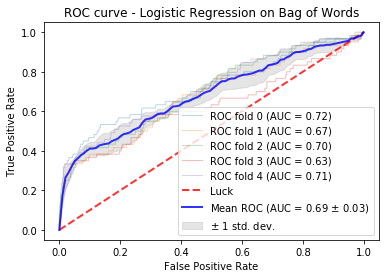

In [20]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc

#X = X_bag
X = CountVectorizer(ngram_range=(1,1)).fit_transform(texts_arr)
y = y_true
n_samples, n_features = X.shape

random_state = np.random.RandomState(0)

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
#classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)
classifier = LogisticRegression(C=1e-3, random_state=random_seed)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Logistic Regression on Bag of Words')
plt.legend(loc="lower right")
plt.show()

# PCA plots